In [ ]:
import numpy as np
import math

# Parâmetros de mercado
S0 = 5.75  # BRL/USD hoje
r_dom = 0.03  # taxa BRL (doméstica)
r_for = 0.005  # taxa USD (estrangeira)
sigma = 0.25  # volatilidade anual
notional_per_option = 1_000_000 / 100  # 100 opções no total
steps_per_year = 12  # discretização mensal

def binomial_tree_option(S0, K, T, r, sigma, n, option_type='call', style='european'):
    dt = T / n
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    q = (np.exp((r - r_for) * dt) - d) / (u - d)
    discount = np.exp(-r * dt)

    # Cria a árvore de preços
    prices = np.zeros((n + 1, n + 1))
    for i in range(n + 1):
        for j in range(i + 1):
            prices[j, i] = S0 * (u ** (i - j)) * (d ** j)

    # Valor na maturidade
    option_values = np.zeros_like(prices)
    for j in range(n + 1):
        if option_type == 'call':
            option_values[j, n] = max(0, prices[j, n] - K)
        else:
            option_values[j, n] = max(0, K - prices[j, n])

    # Retropropagação
    for i in range(n - 1, -1, -1):
        for j in range(i + 1):
            expected = discount * (q * option_values[j, i + 1] + (1 - q) * option_values[j + 1, i + 1])
            if style == 'european':
                option_values[j, i] = expected
            else:
                intrinsic = max(0, prices[j, i] - K) if option_type == 'call' else max(0, K - prices[j, i])
                option_values[j, i] = max(expected, intrinsic)

    return option_values[0, 0]

def expected_value_real_prob(S0, K, T, sigma, n, p_real_up, option_type='call'):
    dt = T / n
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u

    # Cria árvore de preços
    prices = np.zeros((n + 1, n + 1))
    for i in range(n + 1):
        for j in range(i + 1):
            prices[j, i] = S0 * (u ** (i - j)) * (d ** j)

    # Valor na maturidade
    payoffs = np.zeros(n + 1)
    for j in range(n + 1):
        if option_type == 'call':
            payoffs[j] = max(0, prices[j, n] - K)
        else:
            payoffs[j] = max(0, K - prices[j, n])

    # Probabilidades reais binomiais
    expected = 0
    for j in range(n + 1):
        prob = math.comb(n, j) * (p_real_up ** (n - j)) * ((1 - p_real_up) ** j)
        expected += prob * payoffs[j]

    return expected

# Define os grupos de opções
options = [
    {'K': 5600, 'T': 0.25, 'type': 'call', 'style': 'european', 'qty': 25},
    {'K': 5800, 'T': 0.5,  'type': 'call', 'style': 'european', 'qty': 25},
    {'K': 6000, 'T': 0.5,  'type': 'put',  'style': 'american', 'qty': -25},
    {'K': 6200, 'T': 0.666,'type': 'put',  'style': 'american', 'qty': 25}
]

# Calcula o valor de cada grupo
print("== Valor do portfólio atual (modelo binomial neutro ao risco) ==")
total_value = 0
for opt in options:
    n_steps = int(opt['T'] * steps_per_year)
    val = binomial_tree_option(S0, opt['K'], opt['T'], r_dom, sigma, n_steps,
                                option_type=opt['type'], style=opt['style'])
    position_value = val * abs(opt['qty']) * notional_per_option
    if opt['qty'] < 0:
        position_value = -position_value
    print(f"{opt['style'].capitalize()} {opt['type']} - Strike {opt['K']} - T={opt['T']*12:.0f}m: BRL {position_value:,.2f}")
    total_value += position_value

print(f"\nValor total do portfólio: BRL {total_value:,.2f}")

# Valor esperado da segunda opção (com probabilidade real)
K2 = 5800
T2 = 0.5
n2 = int(T2 * steps_per_year)
expected_val = expected_value_real_prob(S0, K2, T2, sigma, n2, p_real_up=0.6, option_type='call')
expected_total = expected_val * 25 * notional_per_option

print(f"\n== Valor esperado (com prob. real) da segunda opção ==")
print(f"Esperado por opção: BRL {expected_val:,.4f}")
print(f"Valor total esperado: BRL {expected_total:,.2f}")


== Valor do portfólio atual (modelo binomial neutro ao risco) ==
European call - Strike 5600 - T=3m: BRL 0.00
European call - Strike 5800 - T=6m: BRL 0.00
American put - Strike 6000 - T=6m: BRL -1,498,562,500.00
American put - Strike 6200 - T=8m: BRL 1,548,562,500.00

Valor total do portfólio: BRL 50,000,000.00

== Valor esperado (com prob. real) da segunda opção ==
Esperado por opção: BRL 0.0000
Valor total esperado: BRL 0.00


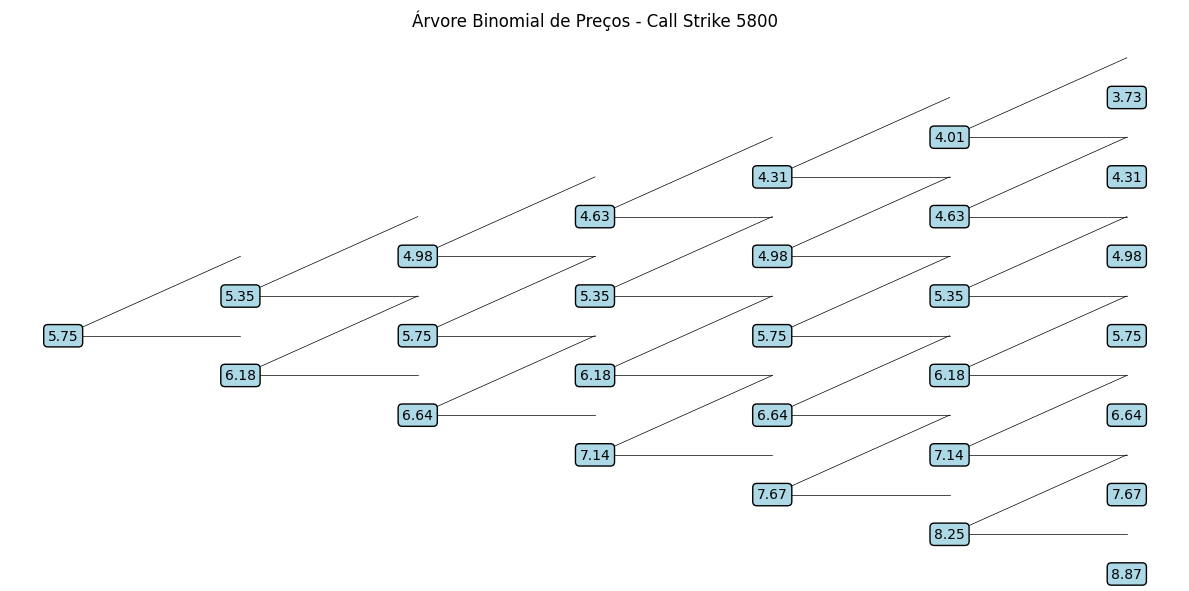

In [ ]:
import matplotlib.pyplot as plt

def plot_binomial_tree(prices, title="Árvore Binomial"):
    n = prices.shape[1] - 1
    fig, ax = plt.subplots(figsize=(12, 6))

    for i in range(n + 1):
        for j in range(i + 1):
            x = i
            y = j - i / 2  # posicionamento vertical
            ax.text(x, y, f"{prices[j, i]:.2f}", ha='center', va='center',
                    bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.3'))
            if i < n:
                ax.plot([x, x + 1], [y, j - i / 2], 'k-', lw=0.5)       # up
                ax.plot([x, x + 1], [y, j + 1 - i / 2], 'k-', lw=0.5)   # down

    ax.set_title(title)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# Exemplo de uso para a segunda opção (european call, T=6m, K=5800)
def get_price_tree(S0, T, sigma, n):
    dt = T / n
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    prices = np.zeros((n + 1, n + 1))
    for i in range(n + 1):
        for j in range(i + 1):
            prices[j, i] = S0 * (u ** (i - j)) * (d ** j)
    return prices

K2 = 5800
T2 = 0.5
n2 = int(T2 * steps_per_year)
price_tree = get_price_tree(S0, T2, sigma, n2)

plot_binomial_tree(price_tree, title=f"Árvore Binomial de Preços - Call Strike {K2}")

